In [6]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
batch_size = 8
train_path = 'datasets/imagenette2/train'
val_path =  'datasets/imagenette2/val'
train_dataloader = torch.utils.data.DataLoader(datasets.ImageFolder(train_path, 
                                                                   transform = transforms.Compose([
                                                                        transforms.RandomResizedCrop(224),
                                                                        transforms.RandomHorizontalFlip(),
                                                                        transforms.ToTensor(),
                                                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                             std=[0.229, 0.224, 0.225])
                                                                   ])), batch_size = batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(datasets.ImageFolder(val_path,
                                                               transform=transforms.Compose([
                                                                   transforms.ToTensor(),
                                                                   transforms.Resize([224, 224]),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std=[0.229, 0.224, 0.225])
                                                               ])),batch_size=batch_size, shuffle=True)

In [12]:
len(test_dataloader)

491

In [14]:
classes = ['tench', 'springer', 'casette_player', 'chain_saw','church', 'French_horn', 'garbage_truck', 'gas_pump', 'golf_ball', 'parachute']

In [16]:
%run resnet_features.ipynb

# Normal ResNet

In [19]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "resnet_imagenette.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_normal = resnet18_features(pretrained=False, filter='None', filter_layer=0)
model_normal.load_state_dict(torch.load(MODEL_SAVE_PATH))
# model_normal = resnet18_features(pretrained=False, filter='None', filter_layer=0)
# model_detail = torch.load('models/imagenette_no_None_0.pth')
# model_normal.to(device)
# model_normal.load_state_dict(model_detail['net'])
# model_normal.eval()

<All keys matched successfully>

In [21]:
def evaluate_model(model, data, device):
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for x_batch, y_batch in data:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = torch.cat([logits, model(x_batch)])
            targets = torch.cat([targets, y_batch])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [23]:
# Model to GPU and eval mode.
model_normal.to(device)
model_normal.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_normal, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet 18 Normal is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet 18 Normal is: 81.43%


In [51]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

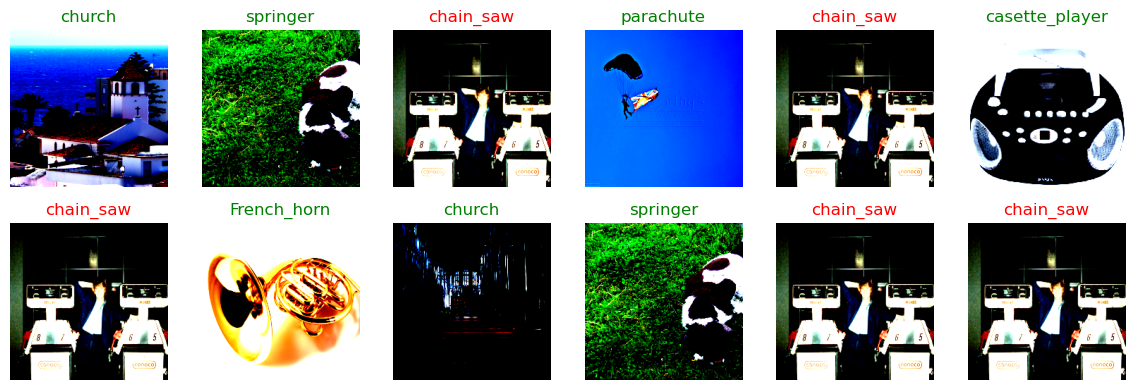

In [57]:
# See random images with their labels
# torch.manual_seed(42)  # setting random seed
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12, 4))
indexes=[]
rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(x_batch), size=[1]).item()
    img, label_gt = x_batch[random_idx], y_batch[random_idx]
    indexes.append(random_idx)
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model_normal(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    
    plt.imshow(img.cpu().numpy(), cmap='gray')
    if label_pred == label_gt:
        plt.title(classes[label_pred], color='g') # for correct prediction
    else:
        plt.title(classes[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout();
plt.show()

In [59]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
# x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [61]:
gc.collect()
torch.cuda.empty_cache()
a_batch_integrad = IntegratedGradients(model_normal).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_normal).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_normal)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

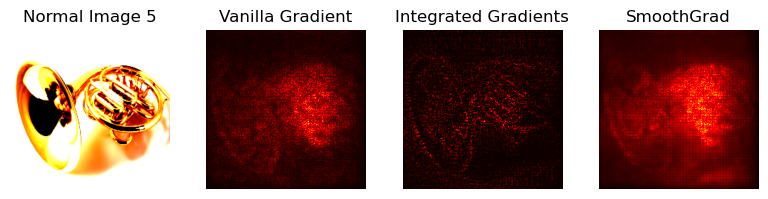

In [62]:
index = indexes[7]
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4, int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")
plt.tight_layout()

plt.savefig('Explanations/resnet_normal.png')
plt.show()

# Adversarial Model

In [66]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "resnet_imagenette_adv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_adv = resnet18_features(pretrained=False, filter='None', filter_layer=0)
model_adv.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [68]:
# Model to GPU and eval mode.
model_adv.to(device)
model_adv.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_adv, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Adversarial is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Adversarial is: 80.33%


In [69]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [70]:
a_batch_integrad_adv = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model_adv).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad_adv[a_batch_integrad_adv<0] = 0
a_batch_saliency_adv = quantus.normalise_func.normalise_by_negative(Saliency(model_adv).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model_adv)
a_batch_smoothgrad_adv = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

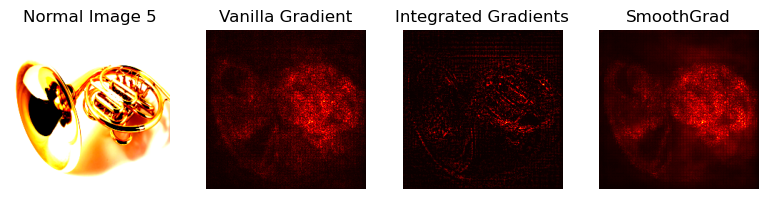

In [71]:
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_adv[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_adv[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_adv[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")

plt.tight_layout()
plt.savefig('Explanations/resnet_adversarial.png')

plt.show()

# L1 UNSTRUCTURED RESNET

In [77]:
def compute_sparsity(model):
    conv0_sparsity = (torch.sum(model.conv1.weight == 0) / model.conv1.weight.nelement()) * 100
    bn0_sparsity = (torch.sum(model.bn1.weight == 0) / model.bn1.weight.nelement()) * 100
    
    conv1_sparsity = (torch.sum(model.layer1[0].conv1.weight == 0) / model.layer1[0].conv1.weight.nelement()) * 100
    conv1_sparsity = (torch.sum(model.layer1[0].bn1.weight == 0) / model.layer1[0].bn1.weight.nelement()) * 100

    conv2_sparsity = (torch.sum(model.layer1[0].conv2.weight == 0) / model.layer1[0].conv2.weight.nelement()) * 100
    conv2_sparsity = (torch.sum(model.layer1[0].bn2.weight == 0) / model.layer1[0].bn2.weight.nelement()) * 100

    conv3_sparsity = (torch.sum(model.layer1[1].conv1.weight == 0) / model.layer1[1].conv1.weight.nelement()) * 100
    conv3_sparsity = (torch.sum(model.layer1[1].bn1.weight == 0) / model.layer1[1].bn1.weight.nelement()) * 100

    conv4_sparsity = (torch.sum(model.layer1[1].conv2.weight == 0) / model.layer1[1].conv2.weight.nelement()) * 100
    conv4_sparsity = (torch.sum(model.layer1[1].bn2.weight == 0) / model.layer1[1].bn2.weight.nelement()) * 100

    conv5_sparsity = (torch.sum(model.layer2[0].conv1.weight == 0) / model.layer2[0].conv1.weight.nelement()) * 100
    conv5_sparsity = (torch.sum(model.layer2[0].bn1.weight == 0) / model.layer2[0].bn1.weight.nelement()) * 100

    conv6_sparsity = (torch.sum(model.layer2[0].conv2.weight == 0) / model.layer2[0].conv2.weight.nelement()) * 100
    conv6_sparsity = (torch.sum(model.layer2[0].bn2.weight == 0) / model.layer2[0].bn2.weight.nelement()) * 100

    conv7_sparsity = (torch.sum(model.layer2[1].conv1.weight == 0) / model.layer2[1].conv1.weight.nelement()) * 100
    conv7_sparsity = (torch.sum(model.layer2[1].bn1.weight == 0) / model.layer2[1].bn1.weight.nelement()) * 100

    conv8_sparsity = (torch.sum(model.layer2[1].conv2.weight == 0) / model.layer2[1].conv2.weight.nelement()) * 100
    conv8_sparsity = (torch.sum(model.layer2[1].bn2.weight == 0) / model.layer2[1].bn2.weight.nelement()) * 100

    conv9_sparsity = (torch.sum(model.layer3[0].conv1.weight == 0) / model.layer3[0].conv1.weight.nelement()) * 100
    conv9_sparsity = (torch.sum(model.layer3[0].bn1.weight == 0) / model.layer3[0].bn1.weight.nelement()) * 100

    conv10_sparsity = (torch.sum(model.layer3[0].conv2.weight == 0) / model.layer3[0].conv2.weight.nelement()) * 100
    conv10_sparsity = (torch.sum(model.layer3[0].bn2.weight == 0) / model.layer3[0].bn2.weight.nelement()) * 100

    conv11_sparsity = (torch.sum(model.layer3[1].conv1.weight == 0) / model.layer3[1].conv1.weight.nelement()) * 100
    conv11_sparsity = (torch.sum(model.layer3[1].bn1.weight == 0) / model.layer3[1].bn1.weight.nelement()) * 100

    conv12_sparsity = (torch.sum(model.layer3[1].conv2.weight == 0) / model.layer3[1].conv2.weight.nelement()) * 100
    conv12_sparsity = (torch.sum(model.layer3[1].bn2.weight == 0) / model.layer3[1].bn2.weight.nelement()) * 100

    conv13_sparsity = (torch.sum(model.layer4[0].conv1.weight == 0) / model.layer4[0].conv1.weight.nelement()) * 100
    conv13_sparsity = (torch.sum(model.layer4[0].bn1.weight == 0) / model.layer4[0].bn1.weight.nelement()) * 100

    conv14_sparsity = (torch.sum(model.layer4[0].conv2.weight == 0) / model.layer4[0].conv2.weight.nelement()) * 100
    conv14_sparsity = (torch.sum(model.layer4[0].bn2.weight == 0) / model.layer4[0].bn2.weight.nelement()) * 100

    conv15_sparsity = (torch.sum(model.layer4[1].conv1.weight == 0) / model.layer4[1].conv1.weight.nelement()) * 100
    conv15_sparsity = (torch.sum(model.layer4[1].bn1.weight == 0) / model.layer4[1].bn1.weight.nelement()) * 100

    conv16_sparsity = (torch.sum(model.layer4[1].conv2.weight == 0) / model.layer4[1].conv2.weight.nelement()) * 100
    conv16_sparsity = (torch.sum(model.layer4[1].bn2.weight == 0) / model.layer4[1].bn2.weight.nelement()) * 100
    
    fc_sparsity = (torch.sum(model.fc.weight == 0) / model.fc.weight.nelement()) * 100

    num =  torch.sum(model.conv1.weight == 0) + torch.sum(model.bn1.weight == 0) + torch.sum(model.layer1[0].conv1.weight == 0) + torch.sum(model.layer1[0].bn1.weight == 0) + torch.sum(model.layer1[0].conv2.weight == 0) +  torch.sum(model.layer1[0].bn2.weight == 0) + torch.sum(model.layer1[1].conv1.weight == 0) +  torch.sum(model.layer1[1].bn1.weight == 0) + torch.sum(model.layer1[1].conv2.weight == 0) + torch.sum(model.layer1[1].bn2.weight == 0) +torch.sum(model.layer2[0].conv1.weight == 0) + torch.sum(model.layer2[0].bn1.weight == 0) + torch.sum(model.layer2[0].conv2.weight == 0) +  torch.sum(model.layer2[0].bn2.weight == 0) + torch.sum(model.layer2[1].conv1.weight == 0) + torch.sum(model.layer2[1].bn1.weight == 0) + torch.sum(model.layer2[1].conv2.weight == 0) + torch.sum(model.layer2[1].bn2.weight == 0) + torch.sum(model.layer3[0].conv1.weight == 0) + torch.sum(model.layer3[0].bn1.weight == 0) + torch.sum(model.layer3[0].conv2.weight == 0) +  torch.sum(model.layer3[0].bn2.weight == 0) + torch.sum(model.layer3[1].conv1.weight == 0) +  torch.sum(model.layer3[1].bn1.weight == 0) + torch.sum(model.layer3[1].conv2.weight == 0) + torch.sum(model.layer3[1].bn2.weight == 0) + torch.sum(model.layer4[0].conv1.weight == 0) + torch.sum(model.layer4[0].bn1.weight == 0) + torch.sum(model.layer4[0].conv2.weight == 0) +  torch.sum(model.layer4[0].bn2.weight == 0) + torch.sum(model.layer4[1].conv1.weight == 0) +  torch.sum(model.layer4[1].bn1.weight == 0) + torch.sum(model.layer4[1].conv2.weight == 0) + torch.sum(model.layer4[1].bn2.weight == 0) + torch.sum(model.fc.weight == 0) 
                                                                                                                                                                                                                                                                                                                                    
    denom =  model.conv1.weight.nelement() +  model.bn1.weight.nelement() + model.layer1[0].conv1.weight.nelement() + model.layer1[0].bn1.weight.nelement() + model.layer1[0].conv2.weight.nelement() + model.layer1[0].bn2.weight.nelement() + model.layer1[1].conv1.weight.nelement() +  model.layer1[1].bn1.weight.nelement() + model.layer1[1].conv2.weight.nelement() + model.layer1[1].bn2.weight.nelement() +  model.layer2[0].conv1.weight.nelement() + model.layer2[0].bn1.weight.nelement() + model.layer2[0].conv2.weight.nelement() + model.layer2[0].bn2.weight.nelement() + model.layer2[1].conv1.weight.nelement() +  model.layer2[1].bn1.weight.nelement() + model.layer2[1].conv2.weight.nelement() + model.layer2[1].bn2.weight.nelement() +  model.layer3[0].conv1.weight.nelement() + model.layer3[0].bn1.weight.nelement() + model.layer3[0].conv2.weight.nelement() + model.layer3[0].bn2.weight.nelement() + model.layer3[1].conv1.weight.nelement() +  model.layer3[1].bn1.weight.nelement() + model.layer3[1].conv2.weight.nelement() + model.layer3[1].bn2.weight.nelement() +  model.layer4[0].conv1.weight.nelement() + model.layer4[0].bn1.weight.nelement() + model.layer4[0].conv2.weight.nelement() + model.layer4[0].bn2.weight.nelement() + model.layer4[1].conv1.weight.nelement() +  model.layer4[1].bn1.weight.nelement() + model.layer4[1].conv2.weight.nelement() + model.layer4[1].bn2.weight.nelement() + model.fc.weight.nelement()
    global_sparsity = num/denom * 100
    return global_sparsity

In [79]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "resnet_imagenette_l1_unstructured.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_l1_unstructured = resnet18_features(pretrained=False, filter='None', filter_layer=0).to(device)

for name, module in model_l1_unstructured.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"Resnet L1 Unstructured sparsity = {compute_sparsity(model_l1_unstructured):.2f}%")
model_l1_unstructured.load_state_dict(torch.load(MODEL_SAVE_PATH))

Resnet L1 Unstructured sparsity = 19.99%


<All keys matched successfully>

In [81]:
# Model to GPU and eval mode.
model_l1_unstructured.to(device)
model_l1_unstructured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_l1_unstructured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet PL1 Structured is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet PL1 Structured is: 85.94%


In [82]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [83]:
a_batch_integrad_l1 = IntegratedGradients(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_l1[a_batch_integrad_l1<0] = 0
a_batch_saliency_l1 = Saliency(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_l1_unstructured)
a_batch_smoothgrad_l1 = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

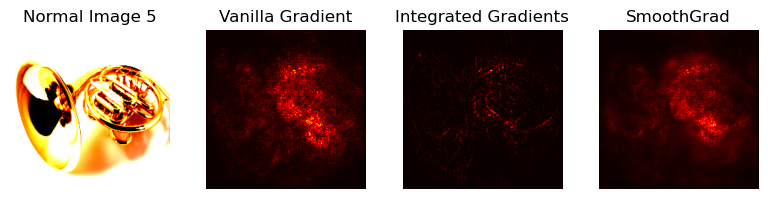

In [84]:

nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_l1[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_l1[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_l1[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")

plt.tight_layout()
plt.savefig('Explanations/resnet_l1_unstructured.png')

plt.show()

# Global Pruning

In [86]:
from pathlib import Path

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "resnet_imagenette_global.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_global =  resnet18_features(pretrained=False, filter='None', filter_layer=0).to(device)

parameters_to_prune = (
    (model_global.conv1, 'weight'),
    (model_global.bn1, 'weight'),
    (model_global.layer1[0].conv1, 'weight'),
    (model_global.layer1[0].bn1, 'weight'),
    (model_global.layer1[0].conv2, 'weight'),
    (model_global.layer1[0].bn2, 'weight'),
    (model_global.layer1[1].conv1, 'weight'),
    (model_global.layer1[1].bn1, 'weight'),
    (model_global.layer1[1].conv2, 'weight'),
    (model_global.layer1[1].bn2, 'weight'),
    (model_global.layer2[0].conv1, 'weight'),
    (model_global.layer2[0].bn1, 'weight'),
    (model_global.layer2[0].conv2, 'weight'),
    (model_global.layer2[0].bn2, 'weight'),
    (model_global.layer2[1].conv1, 'weight'),
    (model_global.layer2[1].bn1, 'weight'),
    (model_global.layer2[1].conv2, 'weight'),
    (model_global.layer2[1].bn2, 'weight'),
    (model_global.layer3[0].conv1, 'weight'),
    (model_global.layer3[0].bn1, 'weight'),
    (model_global.layer3[0].conv2, 'weight'),
    (model_global.layer3[0].bn2, 'weight'),
    (model_global.layer3[1].conv1, 'weight'),
    (model_global.layer3[1].bn1, 'weight'),
    (model_global.layer3[1].conv2, 'weight'),
    (model_global.layer3[1].bn2, 'weight'),
    (model_global.layer4[0].conv1, 'weight'),
    (model_global.layer4[0].bn1, 'weight'),
    (model_global.layer4[0].conv2, 'weight'),
    (model_global.layer4[0].bn2, 'weight'),
    (model_global.layer4[1].conv1, 'weight'),
    (model_global.layer4[1].bn1, 'weight'),
    (model_global.layer4[1].conv2, 'weight'),
    (model_global.layer4[1].bn2, 'weight'),
    (model_global.fc, 'weight')
)

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"Resnet global sparsity = {compute_sparsity(model_global):.2f}%")

        
model_global.load_state_dict(torch.load(MODEL_SAVE_PATH))



Iterative Global pruning round = 1
Resnet global sparsity = 20.00%


<All keys matched successfully>

In [87]:
# Model to GPU and eval mode.
model_global.to(device)
model_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_global, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet Pruned Global is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet Pruned Global is: 85.76%


In [88]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [89]:
a_batch_integrad_global = IntegratedGradients(model_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_global[a_batch_integrad_global<0] = 0
a_batch_saliency_global =Saliency(model_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_global)
a_batch_smoothgrad_global = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

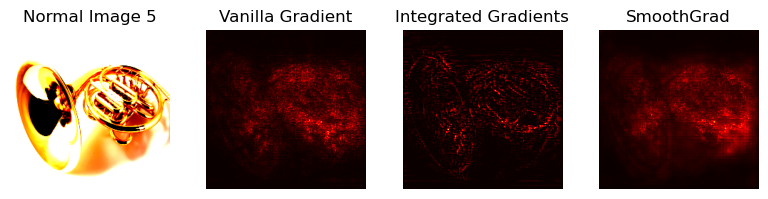

In [90]:
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_global[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_global[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_global[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")

plt.tight_layout()
plt.savefig('Explanations/resnet_global.png')

plt.show()

# Pruning Layered Structure

In [92]:
def count_params(model):
    total_parameters = 0
    for layer, param in model.named_parameters():
        total_parameters += torch.count_nonzero(param.data)
    return total_parameters

In [93]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "resnet_imagenette_structured.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_structured = resnet18_features(pretrained=False, filter='None', filter_layer=0).to(device)

 # Prune layer-wise in a structured manner-
prune.ln_structured(model_structured.conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer1[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer1[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer1[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer1[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer2[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer2[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer2[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer2[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer3[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer3[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer3[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer3[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer4[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer4[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer4[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer4[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)

prune.ln_structured(model_structured.fc, name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"Resnet structrured sparsity = {compute_sparsity(model_structured):.2f}%")

model_structured.load_state_dict(torch.load(MODEL_SAVE_PATH))


Resnet structrured sparsity = 9.99%


<All keys matched successfully>

In [94]:
new_params = count_params(model_structured)
print(f"Pruned Resnet model has {new_params} trainable parameters")

Pruned Resnet model has 11181442 trainable parameters


In [95]:
# Model to GPU and eval mode.
model_structured.to(device)
model_structured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_structured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet Pruned Layered Structure is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet Pruned Layered Structure is: 80.64%


In [96]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [97]:
a_batch_integrad_structured = IntegratedGradients(model_structured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_structured[a_batch_integrad_structured<0] = 0
a_batch_saliency_structured = Saliency(model_structured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_structured)
a_batch_smoothgrad_structured = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

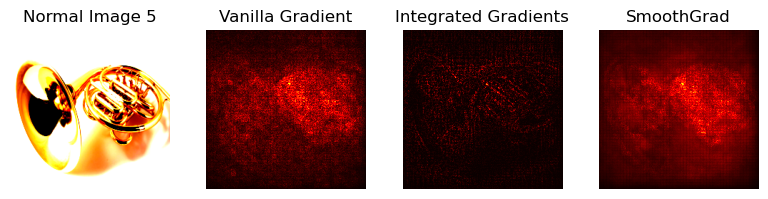

In [98]:

nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_structured[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_structured[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_structured[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")

plt.tight_layout()
plt.savefig('Explanations/resnet_layered_structure.png')

plt.show()

# Quantitative Metrics

In [ ]:
def explainer_wrapper(**kwargs):
    if kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")



def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    std = kwargs.get("std", 0.15)  # Standard deviation for input noise
    n = kwargs.get("n", 10)  # Number of noisy samples
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 3),kwargs.get("img_size", 224),kwargs.get("img_size", 224),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        )
    saliency = Saliency(model)
    
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation




In [ ]:
xai_method=["SmoothGrad"]
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def filter_and_compute_road_saliency_ig(model, test_loader,method, device):

    faithfulness = quantus.ROAD(
    noise=0.01,
    perturb_func=quantus.perturb_func.noisy_linear_imputation,
    percentages=list(range(1, 100, 5)),
    display_progressbar=False)


    score_faithfulness = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        print("Here: ", i)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = faithfulness(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain,
                explain_func_kwargs = {"method": method, "softmax": False})
        print("Here 2: ", i)
        
        score_faithfulness.append(scores)
        if len(score_faithfulness) > 100:
            print("Here 3")
            break
    average_values = {}
    for d in score_faithfulness:
        print("Here 4")
        for key, value in d.items():
            if key in average_values:
                average_values[key] += value
            else:
                average_values[key] = value

    # Divide the sum by the number of dictionaries to get the average
    num_dicts = len(score_faithfulness)
    for key in average_values.keys():
        print("Here 5")
        average_values[key] /= num_dicts

    return average_values


In [ ]:
result_normal = filter_and_compute_road_saliency_ig(model_normal, test_dataloader, "Saliency", device)

In [ ]:
result_adv = filter_and_compute_road_saliency_ig(model_adv, test_dataloader,"Saliency", device)

In [ ]:
result_l1 = filter_and_compute_road_saliency_ig(model_l1_unstructured, test_dataloader,"Saliency", device)

In [ ]:
result_global = filter_and_compute_road_saliency_ig(model_global, test_dataloader,"Saliency", device)

In [ ]:
result_structured = filter_and_compute_road_saliency_ig(model_structured, test_dataloader,"Saliency", device)

In [120]:
result_normal = {1: np.float64(0.985176916001797), 11: np.float64(0.9406093297550283), 21: np.float64(0.9028416916773444), 31: np.float64(0.8543888427383359), 41: np.float64(0.8032685215056397), 51: np.float64(0.7248614888432506), 61: np.float64(0.6479488612398864), 71: np.float64(0.5500896125038881), 81: np.float64(0.4410576002823054), 91: np.float64(0.3104449764341038)}

result_adv = {1: np.float64(0.9740599469324871), 11: np.float64(0.9143535504418652), 21: np.float64(0.8796021689930178), 31: np.float64(0.8358838363563313), 41: np.float64(0.7906206305494473), 51: np.float64(0.7355454403255078), 61: np.float64(0.6692719212496765), 71: np.float64(0.5968815816923749), 81: np.float64(0.5021582372776081), 91: np.float64(0.3655457196842611)}

result_l1 = {1: np.float64(0.9771317649311074), 11: np.float64(0.8979898814815569), 21: np.float64(0.8344315538757163), 31: np.float64(0.7603880843532286), 41: np.float64(0.6769208932359158), 51: np.float64(0.5788611988662281), 61: np.float64(0.49161144519367445), 71: np.float64(0.40814145279427344), 81: np.float64(0.3417128988861466), 91: np.float64(0.26729865449708534)}

result_global = {1: np.float64(0.9744500932079034), 11: np.float64(0.9152064097051144), 21: np.float64(0.8527139106764794), 31: np.float64(0.7735665001550186), 41: np.float64(0.6905665784002831), 51: np.float64(0.5964098826367062), 61: np.float64(0.5030960703892657), 71: np.float64(0.41675430093755517), 81: np.float64(0.3524001496111294), 91: np.float64(0.2957949226042335)}

result_structured = {1: np.float64(0.9877285163654708), 11: np.float64(0.9291248653773628), 21: np.float64(0.8818622739339544), 31: np.float64(0.8439807157062132), 41: np.float64(0.7929149504646132), 51: np.float64(0.726414831167032), 61: np.float64(0.6454594733614605), 71: np.float64(0.5549810997688382), 81: np.float64(0.45195462040461887), 91: np.float64(0.32086628040807086)}


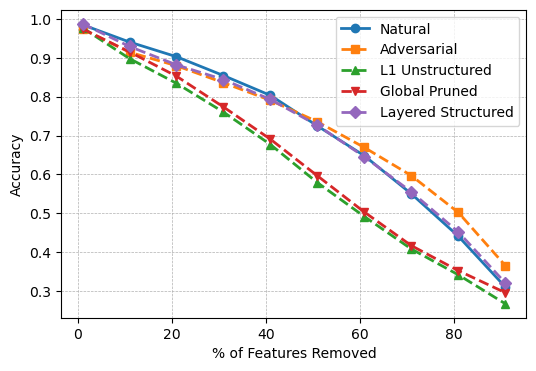

In [122]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1.values()), label='L1 Unstructured', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global.values()), label='Global Pruned', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_structured.values()), label='Layered Structured', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/RESNET_IMAGENET_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
result_normal_ig = filter_and_compute_road_saliency_ig(model_normal, test_dataloader,"IntegratedGradients", device)

In [ ]:
result_adv_ig = filter_and_compute_road_saliency_ig(model_adv, test_dataloader,"IntegratedGradients", device)

In [ ]:
result_l1_ig = filter_and_compute_road_saliency_ig(model_l1_unstructured, test_dataloader,"IntegratedGradients", device)

In [ ]:
result_global_ig = filter_and_compute_road_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)

In [ ]:
result_global_ig = filter_and_compute_road_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)

In [116]:
result_normal_ig = {1: np.float64(0.9257102415047268), 11: np.float64(0.6766015765478892), 21: np.float64(0.5901847546904095), 31: np.float64(0.5407112960138988), 41: np.float64(0.5162772459190045), 51: np.float64(0.512049005677952), 61: np.float64(0.509658068671806), 71: np.float64(0.5038507957933503), 81: np.float64(0.4776769190594899), 91: np.float64(0.4319758313274273)}



result_adv_ig = {1: np.float64(0.8886444057604017), 11: np.float64(0.6322449431425993), 21: np.float64(0.5571836914402861), 31: np.float64(0.5212544067104987), 41: np.float64(0.49812307060356686), 51: np.float64(0.49276542791314504), 61: np.float64(0.49854309708771033), 71: np.float64(0.48866350430173455), 81: np.float64(0.4716889389320149), 91: np.float64(0.41180600691887975)}


result_l1_ig = {1: np.float64(0.9181114868602936), 11: np.float64(0.6624713322279333), 21: np.float64(0.5633448580177112), 31: np.float64(0.5040712063412075), 41: np.float64(0.47045661687977325), 51: np.float64(0.46294446730733463), 61: np.float64(0.4459014802285442), 71: np.float64(0.4252620660542458), 81: np.float64(0.38585791158761024), 91: np.float64(0.33863626558397114)}


result_global_ig = {1: np.float64(0.8984378730270682), 11: np.float64(0.6438073309090356), 21: np.float64(0.566748640453674), 31: np.float64(0.5250444363926915), 41: np.float64(0.49893139583322504), 51: np.float64(0.4897081278366046), 61: np.float64(0.4895906809697718), 71: np.float64(0.47606392674239867), 81: np.float64(0.445828566647415), 91: np.float64(0.3981008636391646)}


result_structured_ig = {1: np.float64(0.9332154488354585), 11: np.float64(0.7019212814616326), 21: np.float64(0.5884850056921093), 31: np.float64(0.5409262437050392), 41: np.float64(0.5149718574878699), 51: np.float64(0.4980913803724213), 61: np.float64(0.48652928959455055), 71: np.float64(0.460116978282072), 81: np.float64(0.4395033440877036), 91: np.float64(0.403327753767895)}


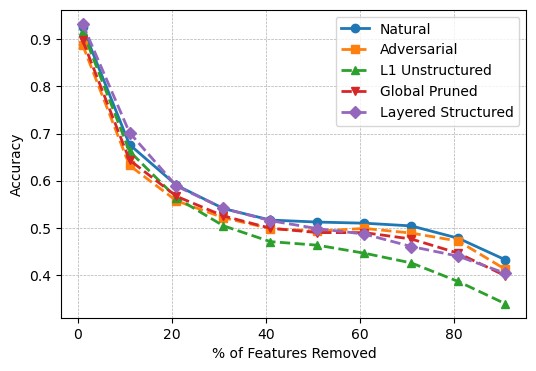

In [118]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal_ig.keys()),list(result_normal_ig.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_adv_ig.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_l1_ig.values()), label='L1 Unstructured', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_global_ig.values()), label='Global Pruned', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_structured_ig.values()), label='Layered Structured', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/RESNET_IMAGENET_IG_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
def filter_and_compute_road_smooth(model, test_loader, device):

    faithfulness = quantus.ROAD(
    noise=0.01,
    perturb_func=quantus.perturb_func.noisy_linear_imputation,
    percentages=list(range(1, 100, 10)),
    display_progressbar=False)


    score_faithfulness = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = faithfulness(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                },
        )
        #print(scores)
        
        score_faithfulness.append(scores)
        if len(score_faithfulness) > 100:
            break
    average_values = {}
    for d in score_faithfulness:
        for key, value in d.items():
            if key in average_values:
                average_values[key] += value
            else:
                average_values[key] = value

    # Divide the sum by the number of dictionaries to get the average
    num_dicts = len(score_faithfulness)
    for key in average_values.keys():
        average_values[key] /= num_dicts

    return average_values

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
result_normal_smooth = filter_and_compute_road_smooth(model_normal, test_dataloader, device)

In [ ]:
result_adv_smooth = filter_and_compute_road_smooth(model_adv, test_dataloader, device)

In [ ]:
result_l1_smooth = filter_and_compute_road_smooth(model_l1_unstructured, test_dataloader, device)

In [ ]:
result_global_smooth = filter_and_compute_road_smooth(model_global, test_dataloader, device)

In [ ]:
result_structured_smooth = filter_and_compute_road_smooth(model_structured, test_dataloader, device)

In [124]:
result_normal_smooth ={1: np.float64(0.9834333959517533), 11: np.float64(0.9164847770366226), 21: np.float64(0.8397299449012687), 31: np.float64(0.765307818924537), 41: np.float64(0.681550711696633), 51: np.float64(0.5876534123916588), 61: np.float64(0.4931000950104948), 71: np.float64(0.4067143119295172), 81: np.float64(0.31780654378464146), 91: np.float64(0.2284064479197357)}


result_adv_smooth ={1: np.float64(0.9675052569821796), 11: np.float64(0.901861972114658), 21: np.float64(0.8471674580913182), 31: np.float64(0.7877902631602134), 41: np.float64(0.7193342593734322), 51: np.float64(0.6412846210780162), 61: np.float64(0.5673225569231836), 71: np.float64(0.4837537245880685), 81: np.float64(0.40315806714829155), 91: np.float64(0.29282535216761574)}

result_l1_smooth ={1: np.float64(0.967466423219195), 11: np.float64(0.8570314872169646), 21: np.float64(0.7679475924735579), 31: np.float64(0.6809292231128254), 41: np.float64(0.5791330997663106), 51: np.float64(0.48864297515336136), 61: np.float64(0.4032152378635825), 71: np.float64(0.3344570334998226), 81: np.float64(0.2614352300719783), 91: np.float64(0.2001218016219137)}

result_global_smooth = {1: np.float64(0.9672570610728368), 11: np.float64(0.8812833074059877), 21: np.float64(0.7984701133392262), 31: np.float64(0.7134886275912096), 41: np.float64(0.6275211824608398), 51: np.float64(0.5401468388939297), 61: np.float64(0.4584391375735543), 71: np.float64(0.37745275529125233), 81: np.float64(0.3095170430548674), 91: np.float64(0.23304836170813725)}

result_structured_smooth = {1: np.float64(0.9843386015901351), 11: np.float64(0.9101644234297657), 21: np.float64(0.8319442785058948), 31: np.float64(0.7693344641590639), 41: np.float64(0.7036393235017321), 51: np.float64(0.6202076012401377), 61: np.float64(0.5242760968830423), 71: np.float64(0.4262233212897687), 81: np.float64(0.33752715386684173), 91: np.float64(0.24778221003866122)}


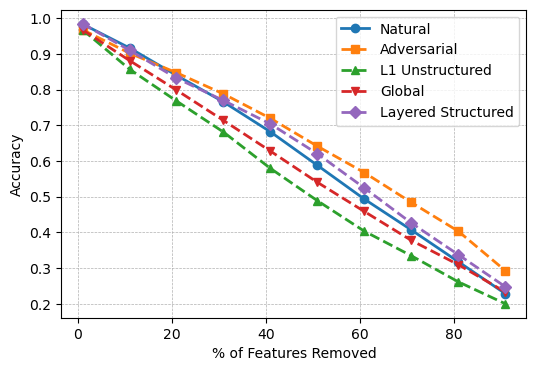

In [126]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal_smooth.keys()),list(result_normal_smooth.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_adv_smooth.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_l1_smooth.values()), label='L1 Unstructured', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_global_smooth.values()), label='Global', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_structured_smooth.values()), label='Layered Structured', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/RESNET_IMAGENET_SMOOTH_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
import math
def filter_and_compute_input_stability_saliency_ig(model, test_loader, method, device):
    
    metrics = quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    )
    score = []
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": method, "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 100:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
normal_input_saliency = filter_and_compute_input_stability_saliency_ig(model_normal, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", normal_input_saliency)

In [ ]:
adversarial_input_saliency = filter_and_compute_input_stability_saliency_ig(model_adv, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", adversarial_input_saliency)

In [ ]:
l1_input_saliency =  filter_and_compute_input_stability_saliency_ig(model_l1_unstructured, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", l1_input_saliency)

In [ ]:
global_input_saliency = filter_and_compute_input_stability_saliency_ig(model_global, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", global_input_saliency)

In [ ]:
layered_input_saliency = filter_and_compute_input_stability_saliency_ig(model_structured, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", layered_input_saliency)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
normal_input_ig  = filter_and_compute_input_stability_saliency_ig(model_normal, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ", normal_input_ig)

In [ ]:
adversarial_input_ig = filter_and_compute_input_stability_saliency_ig(model_adv, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ", adversarial_input_ig)

In [ ]:
l1_input_ig = filter_and_compute_input_stability_saliency_ig(model_l1_unstructured, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ",l1_input_ig)

In [ ]:
global_input_ig = filter_and_compute_input_stability_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ", global_input_ig)

In [ ]:
layered_input_ig = filter_and_compute_input_stability_saliency_ig(model_structured, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ", layered_input_ig)

In [ ]:
import math
def filter_and_compute_input_stability_smooth(model, test_loader, device):
    
    metrics = quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    )
    score = []
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                })
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 100:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
normal_input_smooth  =  filter_and_compute_input_stability_smooth(model_normal, test_dataloader, device)
print("The relative input stability score is: ",normal_input_smooth)

In [ ]:
adversarial_input_smooth =  filter_and_compute_input_stability_smooth(model_adv, test_dataloader, device)
print("The relative input stability score is: ",adversarial_input_smooth)

In [ ]:
l1_input_smooth = filter_and_compute_input_stability_smooth(model_l1_unstructured, test_dataloader, device)
print("The relative input stability score is: ", l1_input_smooth)

In [ ]:
global_input_smooth = filter_and_compute_input_stability_smooth(model_global, test_dataloader, device)
print("The relative input stability score is: ", global_input_smooth)

In [ ]:
layered_input_smooth = filter_and_compute_input_stability_smooth(model_structured, test_dataloader, device)
print("The relative input stability score is: ", layered_input_smooth)

In [30]:
normal_input_saliency = -0.9018778769075133
normal_input_ig = 1.7639805688893246
normal_input_smooth = -1.944678350030911
adversarial_input_saliency =-1.160548799310327
adversarial_input_ig =  1.6541680577038955
adversarial_input_smooth = -1.8976373229502874
l1_input_saliency = -1.1297737362353673
l1_input_ig =  1.7477437234927131
l1_input_smooth = -1.8600018717141973
global_input_saliency =  -1.0756617945463878
global_input_ig = 1.7850837025075994
global_input_smooth = -1.8355369955184282
layered_input_saliency = -1.0354806852445404
layered_input_ig = 1.7671019871058502
layered_input_smooth = -1.9566035671744024

In [32]:
vanilla_gradient = [normal_input_saliency, adversarial_input_saliency, l1_input_saliency, global_input_saliency, layered_input_saliency]
integrated_gradients = [normal_input_ig, adversarial_input_ig, l1_input_ig, global_input_ig, layered_input_ig]
smoothgrad = [normal_input_smooth, adversarial_input_smooth, l1_input_smooth, global_input_smooth, layered_input_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,-0.852044,2.030010,-1.721730
Adversarial Model,-1.160549,1.654168,-1.897637
L1 Unstructured Pruned,-1.129774,1.747744,-1.860002
Global Pruned,-1.075662,1.785084,-1.835537
Layered Structured Pruned,-1.035481,1.767102,-1.956604


In [ ]:
def filter_and_compute_output_stability_saliency_ig(model, test_loader,method, device):
    metrics = quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    )
    score = []
    
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": method, "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 100:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
normal_output_saliency = filter_and_compute_output_stability_saliency_ig(model_normal, test_dataloader,"Saliency", device)
print("The relative output stability score is: ", normal_output_saliency)

In [ ]:
adversarial_output_saliency = filter_and_compute_output_stability_saliency_ig(model_adv, test_dataloader,"Saliency", device)
print("The relative output stability score is: ", adversarial_output_saliency)

In [ ]:
l1_output_saliency = filter_and_compute_output_stability_saliency_ig(model_l1_unstructured, test_dataloader,"Saliency", device)
print("The relative output stability score is: ", l1_output_saliency)

In [ ]:
global_output_saliency = filter_and_compute_output_stability_saliency_ig(model_global, test_dataloader,"Saliency", device)
print("The relative output stability score is: ", global_output_saliency)

In [ ]:
layered_output_saliency = filter_and_compute_output_stability_saliency_ig(model_structured, test_dataloader,"Saliency", device)
print("The relative output stability score is: ",layered_output_saliency )

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
normal_output_ig = filter_and_compute_output_stability_saliency_ig(model_normal, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ", normal_output_ig)

In [ ]:
adversarial_output_ig = filter_and_compute_output_stability_saliency_ig(model_adv, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ", adversarial_output_ig)

In [ ]:
l1_output_ig =  filter_and_compute_output_stability_saliency_ig(model_l1_unstructured, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ",l1_output_ig)

In [ ]:
global_output_ig = filter_and_compute_output_stability_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ",global_output_ig )

In [ ]:
layered_output_ig = filter_and_compute_output_stability_saliency_ig(model_structured, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ", layered_output_ig)

In [ ]:
def filter_and_compute_output_stability_smooth(model, test_loader, device):
    metrics = quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    )
    score = []
    
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                })
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 100:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
normal_output_smooth =  filter_and_compute_output_stability_smooth(model_normal, test_dataloader, device)
print("The relative output stability score is: ",normal_output_smooth)

In [ ]:
adversarial_output_smooth =  filter_and_compute_output_stability_smooth(model_adv, test_dataloader, device)
print("The relative output stability score is: ",adversarial_output_smooth)

In [ ]:
l1_output_smooth = filter_and_compute_output_stability_smooth(model_l1_unstructured, test_dataloader, device)
print("The relative output stability score is: ", l1_output_smooth)

In [ ]:
global_output_smooth = filter_and_compute_output_stability_smooth(model_global, test_dataloader, device)
print("The relative output stability score is: ", global_output_smooth)

In [ ]:
layered_output_smooth = filter_and_compute_output_stability_smooth(model_structured, test_dataloader, device)
print("The relative output stability score is: ", layered_output_smooth)

In [34]:
normal_output_saliency =2.599161006047119
normal_output_ig = 5.38499484348373
normal_output_smooth =  1.7481519399002996
adversarial_output_saliency = 2.7147814343949848
adversarial_output_ig = 5.721554680588458
adversarial_output_smooth =  2.0498308196217243
l1_output_saliency =  3.220550921276016
l1_output_ig =  6.158290193433381
l1_output_smooth =  2.4927760538383663
global_output_saliency = 3.0525925283083337
global_output_ig =  5.9940912189919295
global_output_smooth = 2.3590266769795085

layered_output_saliency = 2.5280284582216526
layered_output_ig = 5.375748826181417
layered_output_smooth =  1.7018587340658444

In [36]:
vanilla_gradient = [normal_output_saliency, adversarial_output_saliency, l1_output_saliency, global_output_saliency, layered_output_saliency]
integrated_gradients = [normal_output_ig, adversarial_output_ig, l1_output_ig, global_output_ig, layered_output_ig]
smoothgrad = [normal_output_smooth, adversarial_output_smooth, l1_output_smooth, global_output_smooth, layered_output_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,3.401133,6.311740,2.598117
Adversarial Model,2.714781,5.721555,2.049831
L1 Unstructured Pruned,3.220551,6.158290,2.492776
Global Pruned,3.052593,5.994091,2.359027
Layered Structured Pruned,2.528028,5.375749,1.701859


In [ ]:
def filter_and_compute_sparsity_saliency_ig(model, test_loader,method, device):
    
    sparsity = quantus.Sparseness(disable_warnings=True, return_aggregate=True)
    score_sparsity = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = sparsity(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": method, "softmax": False})
        score_sparsity.extend(scores)
        if len(score_sparsity) > 100:
            break 
    return np.nanmean(score_sparsity), np.nanstd(score_sparsity)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
normal_sparse_saliency = filter_and_compute_sparsity_saliency_ig(model_normal, test_dataloader,"Saliency", device)
print("The sparsity score is: ", normal_sparse_saliency)

In [ ]:
adversarial_sparse_saliency = filter_and_compute_sparsity_saliency_ig(model_adv, test_dataloader,"Saliency", device)
print("The sparsity score is: ", adversarial_sparse_saliency)

In [ ]:
l1_sparse_saliency =  filter_and_compute_sparsity_saliency_ig(model_l1_unstructured, test_dataloader,"Saliency", device)
print("The sparsity score is: ",l1_sparse_saliency)

In [ ]:
global_sparse_saliency = filter_and_compute_sparsity_saliency_ig(model_global, test_dataloader,"Saliency", device)
print("The sparsity score is: ", global_sparse_saliency)

In [ ]:
layered_sparse_saliency = filter_and_compute_sparsity_saliency_ig(model_structured, test_dataloader,"Saliency", device)
print("The sparsity score is: ",layered_sparse_saliency  )

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
normal_sparse_ig =  filter_and_compute_sparsity_saliency_ig(model_normal, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ",normal_sparse_ig)

In [ ]:
adversarial_sparse_ig = filter_and_compute_sparsity_saliency_ig(model_adv, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ",adversarial_sparse_ig )

In [ ]:
l1_sparse_ig = filter_and_compute_sparsity_saliency_ig(model_l1_unstructured, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ", l1_sparse_ig)

In [ ]:
global_sparse_ig = filter_and_compute_sparsity_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ",global_sparse_ig )

In [ ]:
layered_sparse_ig = filter_and_compute_sparsity_saliency_ig(model_structured, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ", layered_sparse_ig)

In [ ]:
def filter_and_compute_sparsity_smooth(model, test_loader, device):
    
    sparsity = quantus.Sparseness(disable_warnings=True, return_aggregate=True)
    score_sparsity = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = sparsity(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                 explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                })
        score_sparsity.extend(scores)
        if len(score_sparsity) > 100:
            break 
    return np.nanmean(score_sparsity), np.nanstd(score_sparsity)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
normal_sparse_smooth = filter_and_compute_sparsity_smooth(model_normal, test_dataloader, device)
print("The sparsity score is: ",normal_sparse_smooth )

In [ ]:
adversarial_sparse_smooth = filter_and_compute_sparsity_smooth(model_adv, test_dataloader, device)
print("The sparsity score is: ", adversarial_sparse_smooth)

In [ ]:
l1_sparse_smooth = filter_and_compute_sparsity_smooth(model_l1_unstructured, test_dataloader, device)
print("The sparsity score is: ", l1_sparse_smooth)

In [ ]:
global_sparse_smooth = filter_and_compute_sparsity_smooth(model_global, test_dataloader, device)
print("The sparsity score is: ", global_sparse_smooth)

In [ ]:
layered_sparse_smooth =  filter_and_compute_sparsity_smooth(model_structured, test_dataloader, device)
print("The sparsity score is: ",layered_sparse_smooth)

In [38]:
normal_sparse_saliency = 0.39796420125163795
normal_sparse_ig = 0.5671080835443905
normal_sparse_smooth =0.3147218970987349
adversarial_sparse_saliency = 0.4375360435900284
adversarial_sparse_ig = 0.6048284025582602
adversarial_sparse_smooth =0.3669857695133375
l1_sparse_saliency = 0.4568560277463762
l1_sparse_ig = 0.5983691256906815
l1_sparse_smooth = 0.36971884084258
global_sparse_saliency = 0.48063660306696004
global_sparse_ig =0.6145603272194505
global_sparse_smooth =0.39395345661325437
layered_sparse_saliency = 0.36220758091028465
layered_sparse_ig = 0.507593817122505
layered_sparse_smooth =  0.2800138554806231

In [40]:
vanilla_gradient = [normal_sparse_saliency, adversarial_sparse_saliency, l1_sparse_saliency, global_sparse_saliency, layered_sparse_saliency]
integrated_gradients = [normal_sparse_ig, adversarial_sparse_ig, l1_sparse_ig, global_sparse_ig, layered_sparse_ig]
smoothgrad = [normal_sparse_smooth, adversarial_sparse_smooth, l1_sparse_smooth, global_sparse_smooth, layered_sparse_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,0.582447,0.691625,0.489419
Adversarial Model,0.437536,0.604828,0.366986
L1 Unstructured Pruned,0.456856,0.598369,0.369719
Global Pruned,0.480637,0.614560,0.393953
Layered Structured Pruned,0.362208,0.507594,0.280014
